# Project 2: MD using HOOMD
Jenny Fothergill 


The structure of this assignment will be a little wonky. I will answer the prompts explicitly using <span style="color:purple">purple text</span>


Some helper sites:

https://hoomd-blue.readthedocs.io/en/stable/

https://freud.readthedocs.io/en/stable/examples/module_intros/Density-RDF-BinWidth.html

https://nbviewer.jupyter.org/github/joaander/hoomd-examples/blob/master/Analysis%20-%20Accessing%20system%20configurations%20in%20python.ipynb

https://nbviewer.jupyter.org/github/joaander/hoomd-examples/blob/maste/Analysis%20-%20Quantitative%20-%20Online%20analysis%20with%20Freud.ipynb

In [3]:
#Bring in our old favorites.
import hoomd
import hoomd.md
import numpy as np
import freud #library for performing structural analysis
import matplotlib.pyplot as plt
import ex_render
import time
import PIL
import IPython.display
import scipy
from scipy import signal
import pickle
from prettytable import PrettyTable
import scipy.optimize as opt
%matplotlib inline 
# %matplotlib notebook

# This is a helper class for automating RDF calculations with Freud
class rdf_analyze:
    def __init__(self, system):
        self.system = system;
        # Updated below to work with small systems
        self.rdf = freud.density.RDF(rmax=min(system.box.Lx/2,4), dr=0.01); #Can update range and stepsize here
        
    def __call__(self, step):
        '''This special function defines what happens when we "register" the callback below'''
        snap = system.take_snapshot();
        pos = snap.particles.position;
        box = freud.box.Box(snap.box.Lx, snap.box.Ly, snap.box.Lz);
        self.rdf.accumulate(box, pos, pos);
        
def autocorr1D(array):
    '''Takes in a linear numpy array, performs autocorrelation
       function and returns normalized array with half the length 
       of the input'''
    ft = np.fft.rfft(array-np.average(array)) 
    acorr = np.fft.irfft(ft*np.conjugate(ft))/(len(array)*np.var(array))
    return acorr[0:len(acorr)//2]

def get_decorr(acorr):
    return np.argmin(acorr>0)

def error_analysis(data):
    """Returns the standard and relative error given a dataset in a 1D numpy array"""
    serr = np.std(data)/np.sqrt(len(data))
    rel_err = np.abs(100* serr/np.average(data))
    return (serr, rel_err)
  

In [2]:
times = []

In [5]:
start = time.time()
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.2), n=7) #Initial config. 
# Play with different sizes, pre-equilibrated configurations.
# Note: you can write out configurations with https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-dump.html
# Note: And you can read  configurations with https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-init.html
# Note: In concert, you can use these to start new simulations from old snapshots to skip the equilibration period 
# of a job
analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
# high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
hoomd.analyze.log(filename="outputs/log-output.log", quantities=['potential_energy', 
                                                         'kinetic_energy', 
                                                         'pressure', 
                                                         'temperature'], 
                  period=100,overwrite=True) # get some observables!
hoomd.dump.gsd("outputs/trajectory.gsd", period=2e3, group=all, overwrite=True) # write out configurations periodically. 
# Can skip if doing all analysis in real-time
hoomd.run(1e4) # make it go for this many steps
end = time.time()
print("{:.4f} seconds".format(end-start))
times.append(end-start)

notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 10000 / 10000 | TPS 2939.82 | ETA 00:00:00
Average TPS: 2939.13
---------
-- Neighborlist stats:
320 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 81 / n_neigh_avg: 36.8659
shortest rebuild period: 16
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 4 / n_max: 75 / n_avg: 42.875
** run complete **
3.4287 seconds


Text(0, 0.5, 'potential_energy')

/Users/jennyfothergill/miniconda3/envs/hoomd/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


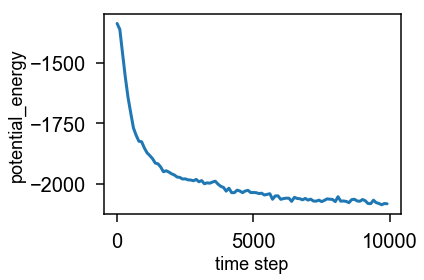

In [6]:
data = np.genfromtxt(fname='outputs/log-output.log', skip_header=True)
plt.plot(data[:,0], data[:,1]) # 0th index is step
plt.xlabel('time step', fontsize=18)
plt.ylabel('potential_energy', fontsize=18) # 1th index is PE

In [7]:
plt.plot(analyzer.rdf.R, analyzer.rdf.RDF) # use that accumulated RDF!
plt.xlabel('r', fontsize=18)
plt.ylabel('g_AA', fontsize=18)

Text(0, 0.5, 'g_AA')

Initial


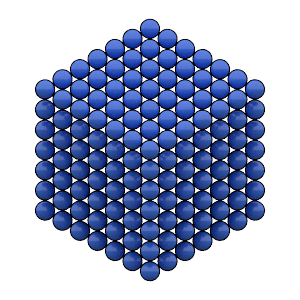

In [8]:
print("Initial")
snapshot = hoomd.data.gsd_snapshot('outputs/trajectory.gsd',frame=0)
ex_render.render_sphere_frame(snapshot)

Final


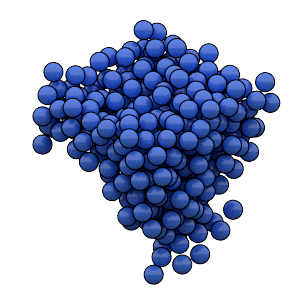

In [213]:
print("Final")
snapshot = hoomd.data.gsd_snapshot('outputs/trajectory.gsd',frame=-1)
ex_render.render_sphere_frame(snapshot)

In [10]:
# Can take a bit of time to read in the trajectory and render it. Be patient!
ex_render.display_movie(ex_render.render_sphere_frame, 'outputs/trajectory.gsd');

In [11]:
times2 = []

In [14]:
start2 = time.time()
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.2), n=7) #Initial config. 
#analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
# high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
hoomd.analyze.log(filename="outputs/log-output.log", quantities=['potential_energy', 
                                                         'kinetic_energy', 
                                                         'pressure',
                                                         'temperature'], 
                  period=100,overwrite=True) # get some observables!
hoomd.dump.gsd("outputs/trajectory.gsd", period=2e3, group=all, overwrite=True) # write out configurations periodically. 
# Can skip if doing all analysis in real-time
hoomd.run(1e4) # make it go for this many steps
end2 = time.time()
print("{:.4f} seconds".format(end2-start2))
times2.append(end2-start2)

notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 10000 / 10000 | TPS 3317.73 | ETA 00:00:00
Average TPS: 3316.13
---------
-- Neighborlist stats:
320 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 81 / n_neigh_avg: 36.8659
shortest rebuild period: 16
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 4 / n_max: 75 / n_avg: 42.875
** run complete **
3.0405 seconds


In [15]:
# probably timeit would be better for this, but...
print("average time with RDF analysis:    {:.2f} +/- {:.2f} seconds {} runs\n".format(np.mean(times),
                                                                                  np.std(times), len(times))+
"average time without RDF analysis: {:.2f} +/- {:.2f} seconds {} runs".format(np.mean(times2),
                                                                           np.std(times2), len(times2)))

average time with RDF analysis:    3.51 +/- 0.14 seconds 3 runs
average time without RDF analysis: 3.03 +/- 0.02 seconds 3 runs


<span style="color:purple">2. Characterize your model’s performance:
    
<span style="color:purple">d. Can you improve the performance of your simulations by changing how frequently you write out data?

OK, so cutting out the RDF analysis saves about 0.25 seconds (total run takes 3 seconds) for 10,000 steps. Because we don't really care about the RDF until it is equilibrated, we can run first without it. Also gsd dump and log file is SO FAST. I don't notice a difference in timing when I cut those out... and because they're so useful, I can't see a good reason not to log them.

notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 18000 / 18000 | TPS 3163.17 | ETA 00:00:00
Average TPS: 3162.39
---------
-- Neighborlist stats:
305 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 83 / n_neigh_avg: 36.9096
shortest rebuild period: 19
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 2 / n_max: 75 / n_avg: 42.875
** run complete **


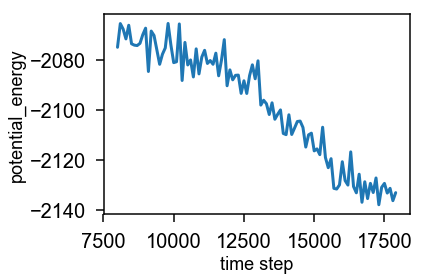

In [16]:
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.read_gsd("outputs/trajectory.gsd",frame=-1)

#analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
# high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
hoomd.analyze.log(filename="outputs/eq_log-output.log", quantities=['potential_energy', 
                                                         'kinetic_energy', 
                                                         'pressure',
                                                         'temperature'], 
                  period=100,overwrite=True) # get some observables!
hoomd.dump.gsd("outputs/eq_trajectory.gsd", period=2e3, group=all, overwrite=True) # write out configurations periodically. 
# Can skip if doing all analysis in real-time
hoomd.run(1e4) # make it go for this many steps

data = np.genfromtxt(fname='outputs/eq_log-output.log', skip_header=True)
plt.plot(data[:,0], data[:,1]) # 0th index is step
plt.xlabel('time step', fontsize=18)
plt.ylabel('potential_energy', fontsize=18) # 1th index is PE
plt.show()

Looks like PE is still decreasing after 20,000 steps. Below shows that the inital frame is final frame from first run.

In [17]:
print("Initial")
snapshot = hoomd.data.gsd_snapshot('outputs/eq_trajectory.gsd',frame=0)
ex_render.render_sphere_frame(snapshot)

Initial


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 26000 / 26000 | TPS 3196.71 | ETA 00:00:00
Average TPS: 3194.69
---------
-- Neighborlist stats:
306 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 85 / n_neigh_avg: 37.3819
shortest rebuild period: 19
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 1 / n_max: 72 / n_avg: 42.875
** run complete **


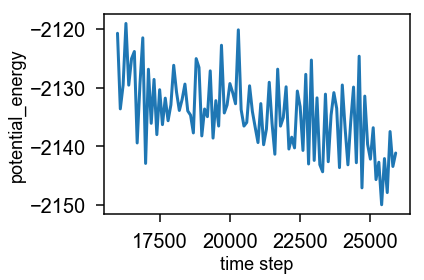

In [18]:
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.read_gsd("outputs/eq_trajectory.gsd",frame=-1)

#analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
# high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
hoomd.analyze.log(filename="outputs/eq_log-output.log", quantities=['potential_energy', 
                                                         'kinetic_energy', 
                                                         'pressure',
                                                         'temperature'], 
                  period=100,overwrite=True) # get some observables!
hoomd.dump.gsd("outputs/eq_trajectory.gsd", period=2e3, group=all, overwrite=True) # write out configurations periodically. 
# Can skip if doing all analysis in real-time
hoomd.run(1e4) # make it go for this many steps

data = np.genfromtxt(fname='outputs/eq_log-output.log', skip_header=True)
plt.plot(data[:,0], data[:,1]) # 0th index is step
plt.xlabel('time step', fontsize=18)
plt.ylabel('potential_energy', fontsize=18) # 1th index is PE
plt.show()

hmm... it looks to me like it's still decreasing but getting close. (30,000 steps)

notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 34000 / 34000 | TPS 3287.72 | ETA 00:00:00
Average TPS: 3285.73
---------
-- Neighborlist stats:
307 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 85 / n_neigh_avg: 37.1837
shortest rebuild period: 15
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 2 / n_max: 71 / n_avg: 42.875
** run complete **


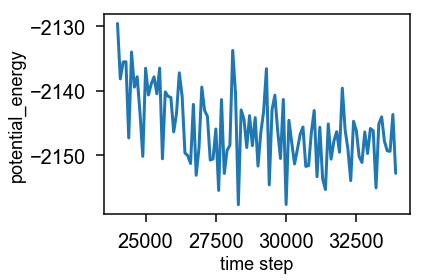

In [19]:
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.read_gsd("outputs/eq_trajectory.gsd",frame=-1)

#analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
# high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
hoomd.analyze.log(filename="outputs/eq_log-output.log", quantities=['potential_energy', 
                                                         'kinetic_energy', 
                                                         'pressure',
                                                         'temperature'], 
                  period=100,overwrite=True) # get some observables!
hoomd.dump.gsd("outputs/eq_trajectory.gsd", period=2e3, group=all, overwrite=True) # write out configurations periodically. 
# Can skip if doing all analysis in real-time
hoomd.run(1e4) # make it go for this many steps

data = np.genfromtxt(fname='outputs/eq_log-output.log', skip_header=True)
plt.plot(data[:,0], data[:,1]) # 0th index is step
plt.xlabel('time step', fontsize=18)
plt.ylabel('potential_energy', fontsize=18) # 1th index is PE
plt.show()

For this statepoint, it looks like 40,000 steps is the magic number. I'm going to run again with RDF logging and reset the step count to zero.

notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 10000 / 10000 | TPS 3041.61 | ETA 00:00:00
Average TPS: 3040.82
---------
-- Neighborlist stats:
308 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 83 / n_neigh_avg: 37.07
shortest rebuild period: 19
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 1 / n_max: 70 / n_avg: 42.875
** run complete **


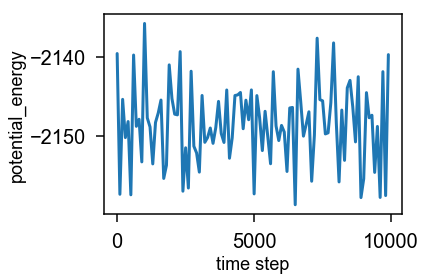

In [20]:
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.read_gsd("eq_trajectory.gsd",frame=-1, time_step=0)

analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
# high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
hoomd.analyze.log(filename="outputs/eq_log-output.log", quantities=['potential_energy', 
                                                         'kinetic_energy', 
                                                         'pressure',
                                                         'temperature'], 
                  period=100,overwrite=True) # get some observables!
hoomd.dump.gsd("outputs/eq_trajectory.gsd", period=2e3, group=all, overwrite=True) # write out configurations periodically. 
# Can skip if doing all analysis in real-time
hoomd.run(1e4) # make it go for this many steps

data = np.genfromtxt(fname='outputs/eq_log-output.log', skip_header=True)
plt.plot(data[:,0], data[:,1]) # 0th index is step
plt.xlabel('time step', fontsize=18)
plt.ylabel('potential_energy', fontsize=18) # 1th index is PE
plt.show()

That looks nice and random, but let's use the autocorrelation to quantify how random.

/Users/jennyfothergill/miniconda3/envs/hoomd/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


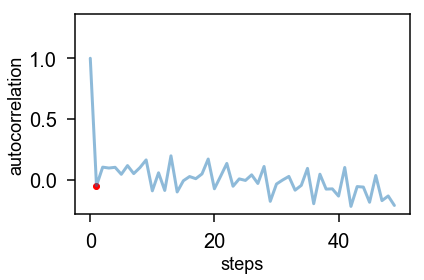

1 steps until decorrelated, 10000 independent samples


Average energy (all samples)
Low T/Low density:   -2112.447 +/- 5.548 (rel error 0.03%)


Average energy (independent samples sampled from beginning)
Low T/Low density:   -2112.447 +/- 5.548 (rel error 0.03%)


Average energy (independent samples sampled from end)
Low T/Low density:   -2112.447 +/- 5.548 (rel error 0.03%)


In [8]:
nsteps = 1e4
    
u = data[:,1]
        
acorr = autocorr1D(u)

dt= get_decorr(acorr)

plt.plot(acorr,alpha=0.5)

plt.scatter(dt,acorr[dt],c='r')
plt.xlabel("steps", fontsize=18)
plt.ylabel("autocorrelation", fontsize=18)
bot,top = plt.ylim()
plt.ylim((bot,top+0.3))
plt.show()


print("""{0} steps until decorrelated, {1} independent samples""".format(dt,int(nsteps//dt)))


print("\n\nAverage energy (all samples)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u),
                                                                             np.std(u),
                                                                             error_analysis(u)[1]))

print("\n\nAverage energy (independent samples sampled from beginning)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u[::dt]),
                                                                             np.std(u[::dt]),
                                                                             error_analysis(u[::dt])[1]))

print("\n\nAverage energy (independent samples sampled from end)")
print("Low T/Low density:   {:0.3f} +/- {:0.3f} (rel error {:0.2f}%)".format(np.average(u[::-dt]),
                                                                             np.std(u[::-dt]),
                                                                             error_analysis(u[::-dt])[1]))


Wow, OK that's the best autocorrelation I've seen so far. A decorrelation step-size of 1 means that every sample is independent! Which suggests that this system is definitely equilibrated. For now, I think I'll run 40,000 steps then collect data. This is probably safe to use for all systems because this is really cold (kT=0.2), and the cold system can be expected to equilibrate more slowly.

<span style="color:purple">2. Characterize your model’s performance:
    
<span style="color:purple">a. How long does it take to equilibrate at the hot and frozen temperatures from above? 
    
After 40,000 steps--the system is definitely equilibrated at kT = 0.2 I know this number will be sufficient for hotter temperatures as well because they will equilibrate faster because they have more kinetic energy and the starting position (evenly distributed through the volume) will be more favorable than it was for the cold temperature which favors a clump.

In [23]:
plt.plot(analyzer.rdf.R, analyzer.rdf.RDF) # use that accumulated RDF!
plt.xlabel('r', fontsize=18)
plt.ylabel('g_AA', fontsize=18)
plt.show()
rdf_loose = np.copy(np.dstack((analyzer.rdf.R,analyzer.rdf.RDF))[0])

kT was really low (0.2), so this system is pretty cold, and the RDF looks solid-like because it has distinct peaks. I'll look at temperature eventually, but next I want to test how small I can make this system and whether smallness speeds things up. In the hoomd.lattice.sc, increasing n maintains the same density, so $\frac{<U>}{N}$ should be roughly the same and the differences we see will be due to surface effects.

In [24]:
sizes = [5,6,7,8,9,10,11,12]
results = {}
for n in sizes:
    # equilibrate
    print("\n\nequilibrating n =", n,"...\n\n")
    
    start=time.time()
    hoomd.context.initialize("") #Turn on hoomd
    system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.2), n=n) #Initial config. 
    #analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
    #hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
    nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
    hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
    all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
    nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
    # high densities.
    nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
    logname = "outputs/log-output{}.log".format(n)
    hoomd.analyze.log(filename=logname, quantities=['potential_energy', 
                                                             'kinetic_energy', 
                                                             'pressure',
                                                             'temperature'], 
                      period=100,overwrite=True) # get some observables!
    gsdname = "outputs/trajectory{}.gsd".format(n)
    hoomd.dump.gsd(gsdname, period=2e3, group=all, overwrite=True) # write out configurations periodically. 
    # Can skip if doing all analysis in real-time
    hoomd.run(4e4) # make it go for this many steps
   

    # collect
    print("\n\ncollecting n =", n,"...\n\n")
    
    start = time.time()
    hoomd.context.initialize("") #Turn on hoomd
    system = hoomd.init.read_gsd(gsdname,frame=-1)
    
    #analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
    #hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
    nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
    hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
    all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
    nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
    # high densities.
    nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
    logname = "outputs/eq_log-output{}.log".format(n)
    hoomd.analyze.log(filename=logname, quantities=['potential_energy', 
                                                             'kinetic_energy', 
                                                             'pressure',
                                                             'temperature'], 
                      period=100,overwrite=True) # get some observables!
    gsdname = "outputs/eq_trajectory{}.gsd".format(n)
    hoomd.dump.gsd(gsdname, period=2e3, group=all, overwrite=True) # write out configurations periodically. 
    # Can skip if doing all analysis in real-time
    hoomd.run(1e4) # make it go for this many steps
    end=time.time()
    
    data = np.genfromtxt(fname=logname, skip_header=True)
    
    results[n] = [end-start, np.mean(data[:,1])/(n**3), get_decorr(autocorr1D(data[:,1])),
                 np.std(data[:,1]),error_analysis(data[:,1])[1]]




equilibrating n = 5 ...


notice(2): Group "all" created containing 125 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:04 | Step 40000 / 40000 | TPS 9440.37 | ETA 00:00:00
Average TPS: 9437.66
---------
-- Neighborlist stats:
1172 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 74 / n_neigh_avg: 33.264
shortest rebuild period: 19
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 7 / n_max: 23 / n_avg: 15.625
** run complete **


collecting n = 5 ...


notice(2): Group "all" created containing 125 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starti

-- Neighborlist stats:
349 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 92 / n_neigh_avg: 40.306
shortest rebuild period: 17
-- Cell list stats:
Dimension: 4, 4, 4
n_min    : 0 / n_max: 29 / n_avg: 15.625
** run complete **


equilibrating n = 11 ...


notice(2): Group "all" created containing 1331 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1331
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 8043 / 40000 | TPS 804.242 | ETA 00:00:39
Time 00:00:20 | Step 15957 / 40000 | TPS 791.377 | ETA 00:00:30
Time 00:00:30 | Step 23858 / 40000 | TPS 790.042 | ETA 00:00:20
Time 00:00:40 | Step 31676 / 40000 | TPS 781.792 | ETA 00:00:10
Time 00:00:50 | Step 39501 / 40000 | TPS 782.136 | ETA 00:00:00
Time 00:00:50 | Step 40000 / 40000 | TPS 795.001 | ETA 00:00:00
Average TPS: 789.959
-

If the above code is run with sigma=1 and n=4, hoomd breaks:

`**ERROR**: nlist: Simulation box is too small! Particles would be interacting with themselves.`

Which I guess means 5 is the smallest (without changing rcut from 2.5) before hoomd breaks! (It makes sense that when rcut for the neighborlist is greater than half the box length--hoomd gets angry.) So I'm interested in where the average energy per N levels off... aka what's the smallest that still gets reasonable results?

In [25]:
# results = [time, <U>/N, decorrelation time, std dev, rel err]
print("n     time(sec)  <U>/N  decorr(steps)  std dev  rel error")
for n in results:
    print("{}\t{:.2f}  \t {:.2f}    \t  {:.0f} \t {:.2f} \t {:.2f}".format(n, results[n][0], results[n][1], 
                                                                    results[n][2],results[n][3],results[n][4]))

n     time(sec)  <U>/N  decorr(steps)  std dev  rel error
5	1.24  	 -5.82    	  1 	 3.36 	 0.05
6	2.02  	 -6.01    	  1 	 4.34 	 0.03
7	3.21  	 -6.16    	  1 	 5.55 	 0.03
8	5.02  	 -6.28    	  1 	 5.46 	 0.02
9	7.87  	 -6.44    	  19 	 12.34 	 0.03
10	9.33  	 -6.40    	  16 	 11.32 	 0.02
11	13.20  	 -6.46    	  1 	 9.35 	 0.01
12	18.35  	 -6.62    	  23 	 63.23 	 0.06


Because this system is so cold, it really wants to clump. If we were looking at a higher temperature, we could look at a smaller system because, in that case, a small section of a periodic volume would representative of a small section of a "real" system. In the case of this really "cold" system, however, within the repeating unit, the atoms are clumping up which is kind of unphysical. (If we were looking at a section of a bulk system at low temperature, we wouldn't expect it to freeze/condense into repeating droplets.) So I guess the smallest system size really depends on temperature. From the above data, it looks like at around n=9 the energy per particle starts levelling off and we start seeing diminishing returns as we increase the system size. Because the volume of the droplet increases faster than the surface area as we increase the number of particles, the per partice energy as we increase N approaches the per particle energy of the bulk.

But because the relative error for each measurement is so low, the energy value that we are calculating for the droplet is pretty accurate. The packing of the particles in the center of the droplet might be close to how they would pack in the bulk, so if we were interested in simulating a bulk measurement we could do one of two things: (1) run a simulation that "shrinks" the box or (2) calculate the difference in energy due to finite size effects. 

In [26]:
# Render all images and save them so you don't have to keep rerendering them
for n in sizes:
    snapshot = hoomd.data.gsd_snapshot('outputs/eq_trajectory{}.gsd'.format(n),frame=-1)
    frame = ex_render.render_sphere_frame(snapshot)
    image = PIL.Image.fromarray(frame[:], mode="RGBA")
    image.save("outputs/output{}.png".format(n))


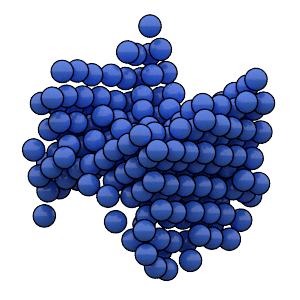

In [27]:
n = 6
IPython.display.Image("outputs/output{}.png".format(n))

If you go through the different n values in the above cell, it looks like we get some pretty densely packed regions--HCP? I'd like to try shrinking the box! (Mike helped me with the code below.) The plan is run it until it crashes and then take then last frame.

In [28]:
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.read_gsd("outputs/eq_trajectory6.gsd",frame=-1)

nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
# high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
hoomd.analyze.log(filename="outputs/shrink_log-output.log", quantities=['potential_energy', 
                                                                'kinetic_energy', 
                                                                'pressure',
                                                                'temperature',
                                                                'lx'], 
                  period=100,overwrite=True) # get some observables!
hoomd.dump.gsd("outputs/shrink_trajectory.gsd", period=2e3, group=all, overwrite=True) # write out configurations periodically. 

size_variant = hoomd.variant.linear_interp([(0, system.box.Lx), (1e6, system.box.Lx/2)], zero=0)

box_resize = hoomd.update.box_resize(L=size_variant)
hoomd.run(1e6)

notice(2): Group "all" created containing 216 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 216
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 127054 / 1046000 | TPS 8105.35 | ETA 00:01:53
Time 00:00:20 | Step 204390 / 1046000 | TPS 7733.55 | ETA 00:01:48
Time 00:00:30 | Step 279764 / 1046000 | TPS 7537.33 | ETA 00:01:41
Time 00:00:40 | Step 351555 / 1046000 | TPS 7179.08 | ETA 00:01:36
Time 00:00:50 | Step 418003 / 1046000 | TPS 6644.8 | ETA 00:01:34
Time 00:01:00 | Step 481664 / 1046000 | TPS 6366.04 | ETA 00:01:28
Time 00:01:10 | Step 541016 / 1046000 | TPS 5935.11 | ETA 00:01:25
Time 00:01:20 | Step 594717 / 1046000 | TPS 5370 | ETA 00:01:24
Time 00:01:30 | Step 641601 / 1046000 | TPS 4688.21 | ETA 00:01:26


**ERROR**: nlist: Simulation box is too small! Particles would be interacting with themselves.


RuntimeError: Error updating neighborlist bins

In [29]:
# Render all images and save them so you don't have to keep rerendering them
n = 6
snapshot = hoomd.data.gsd_snapshot('outputs/shrink_trajectory.gsd',frame=-1)
frame = ex_render.render_sphere_frame(snapshot)
image = PIL.Image.fromarray(frame[:], mode="RGBA")
image.save("outputs/shrink_output{}.png".format(n))
IPython.display.Image("outputs/shrink_output{}.png".format(n))

Ooh, neat. That looks very crystalline. Let's equilibrate and look at some data.

In [30]:
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.read_gsd('outputs/shrink_trajectory.gsd',frame=-1)

#analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
# high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
logname = "outputs/eqshrink_log-output{}.log".format(n)
hoomd.analyze.log(filename=logname, quantities=['potential_energy', 
                                                'kinetic_energy', 
                                                'pressure',
                                                'temperature'], 
                  period=100,overwrite=True) # get some observables!

gsdname = "outputs/eqshrink_trajectory{}.gsd".format(n)
hoomd.dump.gsd(gsdname, period=2e3, group=all, overwrite=True) # write out configurations periodically. 
# Can skip if doing all analysis in real-time
hoomd.run(1e4) # make it go for this many steps

data = np.genfromtxt(fname=logname, skip_header=True)

shrinkresults = [end-start, np.mean(data[:,1])/(n**3), get_decorr(autocorr1D(data[:,1])),
             np.std(data[:,1]),error_analysis(data[:,1])[1]]


notice(2): Group "all" created containing 216 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 216
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:02 | Step 676000 / 676000 | TPS 3793.11 | ETA 00:00:00
Average TPS: 3790.16
---------
-- Neighborlist stats:
0 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 116 / n_neigh_avg: 58.9769
shortest rebuild period: 100
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 22 / n_max: 33 / n_avg: 27
** run complete **


In [31]:
# results = [time, <U>/N, decorrelation time, std dev, rel err]
print("n     time(sec)  <U>/N  decorr(steps)  std dev  rel error")
print("{}\t{:.2f}  \t {:.2f}    \t  {:.0f} \t {:.2f} \t {:.2f}".format(n, shrinkresults[0], shrinkresults[1], 
                                                                       shrinkresults[2],shrinkresults[3],
                                                                       shrinkresults[4]))

n     time(sec)  <U>/N  decorr(steps)  std dev  rel error
6	18.35  	 43.12    	  2 	 2.98 	 0.00


PE is positive... maybe the unit cell was shrunk too much. Let's look at the PE as the box is shrunk.

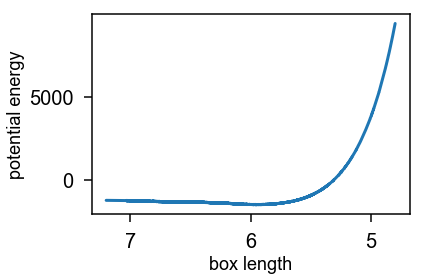

In [32]:
data = np.genfromtxt(fname="outputs/shrink_log-output.log", skip_header=True)
pe= data[:,1]
boxlength = data[:,5]
plt.plot(boxlength, pe) # PE vs boxlength
plt.xlabel('box length', fontsize=18)
plt.ylabel('potential energy', fontsize=18) # 1th index is PE
bot,top = plt.xlim()
plt.xlim(top,bot) # reverse order
plt.show()

Huh, it looks like the energy decreases to a point and then shoots up very fast! As the box was shrunk, the particles were pushed too close.

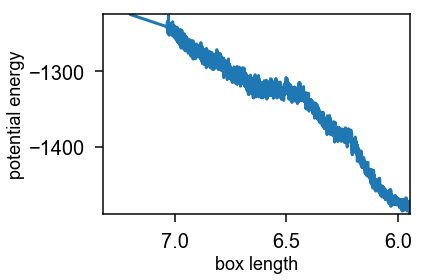

minimum PE:     -1488.69
optimum box length: 5.95
logfile index of min value:  3021


In [34]:
opt_boxlen = boxlength[np.where(pe==min(pe))][0]

plt.plot(boxlength, pe) # PE vs boxlength
plt.xlabel('box length', fontsize=18)
plt.ylabel('potential energy', fontsize=18) # 1th index is PE
plt.xlim(top,opt_boxlen) # reverse order
plt.ylim(min(pe),pe[0])
plt.show()


print("minimum PE:     {:.2f}".format(min(pe)))
print("optimum box length: {:.2f}".format(opt_boxlen))
print("logfile index of min value: ",*np.where(pe==min(pe))[0])

OK, now how do I get the optimum snapshot from the trajectory? I ran 1e6 steps, the logfile was recorded every 100 steps, and the gsd was recorded every 2e3 steps...

lets look around the 151th step of the trajectory?
notice(2): Group "all" created containing 216 particles
5.947203636169434


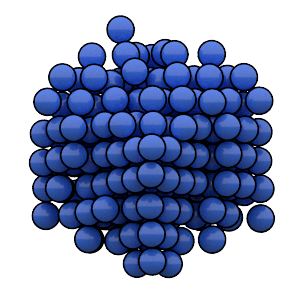

In [35]:
print("lets look around the {:.0f}th step of the trajectory?".format(3021*100/2e3))
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.read_gsd('outputs/shrink_trajectory.gsd',frame=151)
print(system.box.Lx)

n = 6
snapshot = hoomd.data.gsd_snapshot('outputs/shrink_trajectory.gsd',frame=151)
frame = ex_render.render_sphere_frame(snapshot)
image = PIL.Image.fromarray(frame[:], mode="RGBA")
image.save("outputs/shrink_output{}.png".format(n))
IPython.display.Image("outputs/shrink_output{}.png".format(n))

That looks like it worked! Still looks kind of crystalline.

In [36]:
analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) 
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
logname = "outputs/eqshrink_log-output{}.log".format(n)
hoomd.analyze.log(filename=logname, quantities=['potential_energy', 
                                                'kinetic_energy', 
                                                'pressure',
                                                'temperature'], 
                  period=100,overwrite=True) # get some observables!

gsdname = "outputs/eqshrink_trajectory{}.gsd".format(n)
hoomd.dump.gsd(gsdname, period=2e3, group=all, overwrite=True) # write out configurations periodically. 
# Can skip if doing all analysis in real-time
hoomd.run(1e4) # make it go for this many steps

data = np.genfromtxt(fname=logname, skip_header=True)

shrinkresults = [end-start, np.mean(data[:,1])/(n**3), get_decorr(autocorr1D(data[:,1])),
             np.std(data[:,1]),error_analysis(data[:,1])[1]]

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 216
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:15 | Step 358000 / 358000 | TPS 5572.6 | ETA 00:00:00
Average TPS: 5571.02
---------
-- Neighborlist stats:
233 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 61 / n_neigh_avg: 29.1944
shortest rebuild period: 19
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 21 / n_max: 34 / n_avg: 27
** run complete **


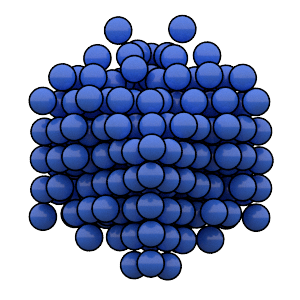

In [37]:
n = 6
snapshot = hoomd.data.gsd_snapshot('outputs/eqshrink_trajectory6.gsd',frame=-1)
frame = ex_render.render_sphere_frame(snapshot)
image = PIL.Image.fromarray(frame[:], mode="RGBA")
image.save("outputs/eqshrink_output{}.png".format(n))
IPython.display.Image("outputs/eqshrink_output{}.png".format(n))

n     time(sec)  <U>/N  decorr(steps)  std dev  rel error
6	18.35  	 -6.84    	  1 	 3.56 	 0.02


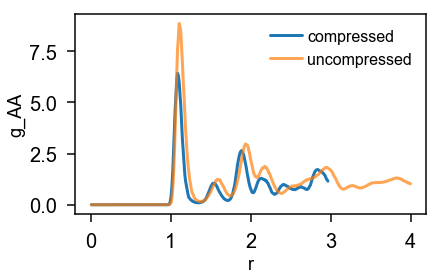

In [47]:
# results = [time, <U>/N, decorrelation time, std dev, rel err]
print("n     time(sec)  <U>/N  decorr(steps)  std dev  rel error")
print("{}\t{:.2f}  \t {:.2f}    \t  {:.0f} \t {:.2f} \t {:.2f}".format(n, shrinkresults[0], shrinkresults[1], 
                                                                       shrinkresults[2],shrinkresults[3],
                                                                       shrinkresults[4]))
rdf_tight = np.dstack((analyzer.rdf.R,analyzer.rdf.RDF))[0]

plt.plot(rdf_tight[:,0],rdf_tight[:,1], label="compressed") 
plt.plot(rdf_loose[:,0],rdf_loose[:,1], label="uncompressed", alpha=0.7) 
plt.legend(fontsize=16)
plt.xlabel('r', fontsize=18)
plt.ylabel('g_AA', fontsize=18)
plt.show()

Hey cool! That's lower than the per particle energy of the large systems! The decorrelation time and relative error look good too.

And the compressed RDF looks even more crystalline (distinct peaks) at long distances. So this was sort of a long tangent, but this could be a way to look at bulk systems at low temp.

<span style="color:purple">2. Characterize your model’s performance:</span>

<span style="color:purple">c. How small is too small to be correct? How large is too large to be practical?</span>
    
OK, so small is good because small is fast. In this case, I kind of discussed how to get around the finite-size effects without really scaling up the system. In this case the system we're looking at is really simple--one type (A) of LJ particles so we don't need a big system, but if we were looking at a system with more particle types or with large, complex structures, we're going to need a larger system. In this case though we just need a system large enough that our box length is at least twice as big as our cutoff distance for our neighborlist. And we should choose that cutoff distance intelligently. Like in the shrunk example I changed rcut to 2 without really checking how large the potential was at that distance.

$V_{LJ} = 4\epsilon\big[\big(\frac{\sigma}{r}\big)^{12} -\big(\frac{\sigma}{r}\big)^{6}\big]$

With $\epsilon$ and $\sigma$ = 1, $V_{LJ}(2)=-0.062$ compared to $V_{LJ}(2.5)=-0.016$, so I guess I'm OK with that.

As for how large, the large (n=12) system took around 20 seconds to equilibrate which is long when you consider that the small (n=6) system, which only took 2 seconds, gives just as good of results!

Let's look at temperatures:

In [15]:
temps = [0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,3.0]

In [29]:
#t_results = {}
#for t in temps:
#    # equilibrate
#    print("\n\nequilibrating T =", t,"...\n\n")
#    
#    start=time.time()
#    hoomd.context.initialize("") #Turn on hoomd
#    system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.2), n=7) #Initial config. 
#    #analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#    #hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
#    nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
#    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
#    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
#    hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
#    all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
#    nvt = hoomd.md.integrate.nvt(group=all, kT=t, tau=.1) 
#    nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
#    logname = "outputs/log-output{}.log".format(t)
#    hoomd.analyze.log(filename=logname, quantities=['potential_energy', 
#                                                    'kinetic_energy', 
#                                                    'pressure',
#                                                    'temperature'], 
#                      period=100,overwrite=True) # get some observables!
#    gsdname = "outputs/trajectory{}.gsd".format(t)
#    hoomd.dump.gsd(gsdname, period=2e3, group=all, overwrite=True) # write out configurations periodically. 
#    # Can skip if doing all analysis in real-time
#    hoomd.run(4e4) # make it go for this many steps
#   
#
#    # collect
#    print("\n\ncollecting T =", t,"...\n\n")
#    
#    hoomd.context.initialize("") #Turn on hoomd
#    system = hoomd.init.read_gsd(gsdname,frame=-1)
#    
#    analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#    hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
#    nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
#    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
#    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
#    hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
#    all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
#    nvt = hoomd.md.integrate.nvt(group=all, kT=t, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
#    # high densities.
#    nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
#    logname = "outputs/eq_log-output{}.log".format(t)
#    hoomd.analyze.log(filename=logname, quantities=['potential_energy', 
#                                                    'kinetic_energy', 
#                                                    'pressure',
#                                                    'temperature'], 
#                      period=100,overwrite=True) # get some observables!
#    gsdname = "outputs/eq_trajectory{}.gsd".format(t)
#    hoomd.dump.gsd(gsdname, period=2e3, group=all, overwrite=True) # write out configurations periodically. 
#    # Can skip if doing all analysis in real-time
#    hoomd.run(1e4) # make it go for this many steps
#    
#
#    data = np.genfromtxt(fname=logname, skip_header=True)
#    
#    t_results[t] = [np.mean(data[:,1])/(7**3), get_decorr(autocorr1D(data[:,1])), np.std(data[:,1]),
#                    error_analysis(data[:,1])[1],np.dstack((analyzer.rdf.R,analyzer.rdf.RDF))[0]]



equilibrating T = 0.2 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 33900 / 40000 | TPS 3389.98 | ETA 00:00:01
Time 00:00:12 | Step 40000 / 40000 | TPS 3484.73 | ETA 00:00:00
Average TPS: 3403.69
---------
-- Neighborlist stats:
1232 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 80 / n_neigh_avg: 37.8338
shortest rebuild period: 16
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 6 / n_max: 73 / n_avg: 42.875
** run complete **


collecting T = 0.2 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          :

Time 00:00:03 | Step 48000 / 48000 | TPS 2574.09 | ETA 00:00:00
Average TPS: 2573.55
---------
-- Neighborlist stats:
931 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 62 / n_neigh_avg: 29.0321
shortest rebuild period: 7
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 34 / n_max: 51 / n_avg: 42.875
** run complete **


equilibrating T = 1.4 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 27854 / 40000 | TPS 2785.28 | ETA 00:00:04
Time 00:00:14 | Step 40000 / 40000 | TPS 2830.54 | ETA 00:00:00
Average TPS: 2798.54
---------
-- Neighborlist stats:
4057 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 59 / n_neigh_avg: 29.0029
shortest 

In [30]:
#with open('t_results.pickle', 'wb') as handle:
#    pickle.dump(t_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('t_results.pickle', 'rb') as handle:
    t_results = pickle.load(handle)

In [31]:
# t_results = [<U>/N, decorrelation time, std dev, rel err, rdf]
print("T     <U>/N  decorr(steps)   std dev     rel error")
for t in temps:

    print("{}\t{:.2f}    \t  {:.0f} \t {:.2f}   \t{:.2f}".format(t, t_results[t][0], t_results[t][1], 
                                                                    t_results[t][2],t_results[t][3],t_results[t][4]))

T     <U>/N  decorr(steps)   std dev     rel error
0.2	-6.16    	  1 	 5.55   	0.03
0.4	-5.53    	  3 	 13.74   	0.07
0.6	-4.77    	  3 	 24.36   	0.15
0.8	-3.96    	  21 	 23.04   	0.17
1.0	-3.78    	  6 	 16.18   	0.12
1.2	-3.65    	  5 	 15.96   	0.13
1.4	-3.57    	  3 	 16.64   	0.14
1.6	-3.48    	  1 	 18.81   	0.16
1.8	-3.40    	  3 	 21.85   	0.19
2.0	-3.30    	  3 	 20.65   	0.18
3.0	-2.94    	  2 	 32.46   	0.32


Good! The energies look resonable (lower T should have lower average per particle energy) and the standard deviation/relative error/decorrelation time suggest that all temps have equilibrated. Let's look at the PE vs. steps of the equilibrated runs just to check:

/Users/jennyfothergill/miniconda3/envs/hoomd/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


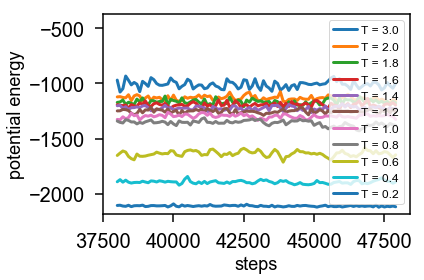

In [32]:
for t in temps[::-1]:
    logname = "outputs/eq_log-output{}.log".format(t)
    data = np.genfromtxt(fname=logname, skip_header=True)
    plt.plot(data[:,0],data[:,1],label="T = {}".format(t))
    
plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('steps', fontsize=18)
plt.ylabel('potential energy', fontsize=18)
bot,top = plt.ylim()
plt.ylim(bot, top+500)
plt.show()

Nice--horizontal squiggles. Let's look at the RDFs:

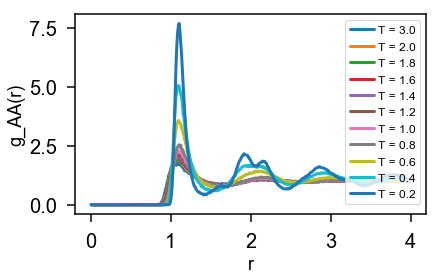

In [33]:
for t in temps[::-1]:
    plt.plot(t_results[t][4][:,0],t_results[t][4][:,1],label="T = {}".format(t))
plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('r', fontsize=18)
plt.ylabel('g_AA(r)', fontsize=18)
plt.show()

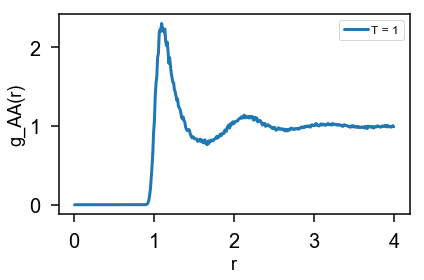

In [71]:
t=1
plt.plot(t_results[t][4][:,0],t_results[t][4][:,1],label="T = {}".format(t))
plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('r', fontsize=18)
plt.ylabel('g_AA(r)', fontsize=18)
plt.show()

OK, so I have an idea: after what we talked about in class, I want to make a T vs. density phase diagram. What if we use peak detection to automate the phase-detection? (e.g. 1 or less peak = gas, 2 peaks = liquid, 3 or more peaks = solid)

In [173]:
def get_peaks(rdf, prominence=0.2):
    """Given an rdf, returns the indices of peaks with set prominence"""
    return scipy.signal.find_peaks(rdf, prominence=prominence)[0]

for t in temps:
    rdf = t_results[t][4][:,1]
    peaks = get_peaks(rdf)
    print("t = {} has {} peaks".format(t,len(peaks)))
    print(peaks)

t = 0.2 has 5 peaks
[110 191 214 285 378]
t = 0.4 has 3 peaks
[109 199 294]
t = 0.6 has 2 peaks
[109 212]
t = 0.8 has 2 peaks
[110 213]
t = 1.0 has 2 peaks
[109 212]
t = 1.2 has 1 peaks
[110]
t = 1.4 has 1 peaks
[108]
t = 1.6 has 1 peaks
[111]
t = 1.8 has 1 peaks
[110]
t = 2.0 has 1 peaks
[110]
t = 3.0 has 1 peaks
[104]


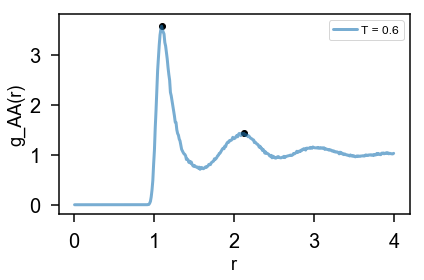

In [174]:
# Play with t here to see that it is picking the peaks correctly :)
t=0.6

rdf = t_results[t][4][:,1]
r = t_results[t][4][:,0]
plt.plot(r,rdf,label="T = {}".format(t), alpha=0.6)
peaks = get_peaks(rdf)
for peak_ind in peaks:
    plt.scatter(r[peak_ind],rdf[peak_ind],c='k')
plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('r', fontsize=18)
plt.ylabel('g_AA(r)', fontsize=18)
plt.show()

That looks about right! Now to run with different densities--I'll do this by changing the lattice parameter, a:

In [16]:
avals = [0.9,1.0,1.1,1.2,1.3,1.4,1.5] 

In [5]:
#t_results_dense = {}
#for a in avals:
#    for t in temps:
#        # equilibrate
#        print("\n\nequilibrating T =", t,"a =", a,"...\n\n")
#
#        hoomd.context.initialize("") #Turn on hoomd
#        system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=a), n=7) #Initial config. 
#        #analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#        #hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
#        nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
#        lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
#        lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
#        hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
#        all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
#        nvt = hoomd.md.integrate.nvt(group=all, kT=t, tau=.1) 
#        nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
#        logname = "outputs/log-output{}{}.log".format(a,t)
#        hoomd.analyze.log(filename=logname, quantities=['potential_energy', 
#                                                        'kinetic_energy', 
#                                                        'pressure',
#                                                        'temperature'], 
#                          period=100,overwrite=True) # get some observables!
#        gsdname = "outputs/trajectory{}{}.gsd".format(a,t)
#        hoomd.dump.gsd(gsdname, period=2e3, group=all, overwrite=True) # write out configurations periodically. 
#        # Can skip if doing all analysis in real-time
#        hoomd.run(4e4) # make it go for this many steps
#
#
#        # collect
#        print("\n\ncollecting T =", t,"a =", a,"...\n\n")
#
#        hoomd.context.initialize("") #Turn on hoomd
#        system = hoomd.init.read_gsd(gsdname,frame=-1)
#
#        analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
#        hoomd.analyze.callback(analyzer, period=100); # Registration of the RDF callback every 100 steps
#        nl = hoomd.md.nlist.cell() # Other neighbor lists you might play with include 'tree'
#        lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
#        lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) # Classic Lennard Jones. No tinkering here!
#        hoomd.md.integrate.mode_standard(dt=0.005) # See how large of a step size you can get away with.
#        all = hoomd.group.all() # This will be 'boilerplate' for Project 2: always integrating all.
#        nvt = hoomd.md.integrate.nvt(group=all, kT=t, tau=.1) # Pick ensemble. Can try NPT with "high" P to equilibrate 
#        # high densities.
#        nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
#        logname = "outputs/eq_log-output{}{}.log".format(a,t)
#        hoomd.analyze.log(filename=logname, quantities=['potential_energy', 
#                                                        'kinetic_energy', 
#                                                        'pressure',
#                                                        'temperature'], 
#                          period=100,overwrite=True) # get some observables!
#        gsdname = "outputs/eq_trajectory{}{}.gsd".format(a,t)
#        hoomd.dump.gsd(gsdname, period=2e3, group=all, overwrite=True) # write out configurations periodically. 
#        # Can skip if doing all analysis in real-time
#        hoomd.run(1e4) # make it go for this many steps
#
#
#        data = np.genfromtxt(fname=logname, skip_header=True)
#
#        t_results_dense[(a,t)] = [np.mean(data[:,1])/(7**3), get_decorr(autocorr1D(data[:,1])), np.std(data[:,1]),
#                        error_analysis(data[:,1])[1],np.dstack((analyzer.rdf.R,analyzer.rdf.RDF))[0]]



equilibrating T = 0.2 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 20794 / 40000 | TPS 2079.32 | ETA 00:00:09
Time 00:00:18 | Step 40000 / 40000 | TPS 2187.9 | ETA 00:00:00
Average TPS: 2129.99
---------
-- Neighborlist stats:
115 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 140 / n_neigh_avg: 70.6472
shortest rebuild period: 19
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 40 / n_max: 45 / n_avg: 42.875
** run complete **


collecting T = 0.2 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          :

Time 00:00:06 | Step 48000 / 48000 | TPS 1614.21 | ETA 00:00:00
Average TPS: 1613.86
---------
-- Neighborlist stats:
735 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 142 / n_neigh_avg: 70.793
shortest rebuild period: 8
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 39 / n_max: 47 / n_avg: 42.875
** run complete **


equilibrating T = 1.4 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 16601 / 40000 | TPS 1660.03 | ETA 00:00:14
Time 00:00:20 | Step 33093 / 40000 | TPS 1649.16 | ETA 00:00:04
Time 00:00:24 | Step 40000 / 40000 | TPS 1689.11 | ETA 00:00:00
Average TPS: 1660.35
---------
-- Neighborlist stats:
3354 normal updates / 400 forced updates / 0 dangerous updates
n

Time 00:00:10 | Step 25001 / 40000 | TPS 2500.06 | ETA 00:00:05
Time 00:00:15 | Step 40000 / 40000 | TPS 2614.75 | ETA 00:00:00
Average TPS: 2541.69
---------
-- Neighborlist stats:
1164 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 101 / n_neigh_avg: 50.1399
shortest rebuild period: 16
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 39 / n_max: 46 / n_avg: 42.875
** run complete **


collecting T = 0.2 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:04 | Step 48000 / 48000 | TPS 2318.94 | ETA 00:00:00
Average TPS: 2318.65
---------
-- Neighborlist stats:
283 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 101 / n_neigh_avg: 49.0671
shortest 

Time 00:00:10 | Step 19973 / 40000 | TPS 1997.27 | ETA 00:00:10
Time 00:00:20 | Step 39302 / 40000 | TPS 1932.87 | ETA 00:00:00
Time 00:00:20 | Step 40000 / 40000 | TPS 1916.4 | ETA 00:00:00
Average TPS: 1964.1
---------
-- Neighborlist stats:
3929 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 105 / n_neigh_avg: 50.895
shortest rebuild period: 7
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 38 / n_max: 47 / n_avg: 42.875
** run complete **


collecting T = 1.4 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:05 | Step 48000 / 48000 | TPS 1804.16 | ETA 00:00:00
Average TPS: 1803.94
---------
-- Neighborlist stats:
981 normal updates / 101 forced updates / 0 dangerous updates
n_neig

Time 00:00:03 | Step 48000 / 48000 | TPS 2659.09 | ETA 00:00:00
Average TPS: 2658.78
---------
-- Neighborlist stats:
304 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 86 / n_neigh_avg: 40.7493
shortest rebuild period: 17
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 25 / n_max: 57 / n_avg: 42.875
** run complete **


equilibrating T = 0.4 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 27811 / 40000 | TPS 2781.04 | ETA 00:00:04
Time 00:00:14 | Step 40000 / 40000 | TPS 2968.11 | ETA 00:00:00
Average TPS: 2835.31
---------
-- Neighborlist stats:
2020 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 84 / n_neigh_avg: 38.4111
shortest

Time 00:00:04 | Step 48000 / 48000 | TPS 2220.59 | ETA 00:00:00
Average TPS: 2220.31
---------
-- Neighborlist stats:
1005 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 77 / n_neigh_avg: 37.6122
shortest rebuild period: 7
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 38 / n_max: 46 / n_avg: 42.875
** run complete **


equilibrating T = 1.6 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 23652 / 40000 | TPS 2365.08 | ETA 00:00:06
Time 00:00:16 | Step 40000 / 40000 | TPS 2346.84 | ETA 00:00:00
Average TPS: 2357.3
---------
-- Neighborlist stats:
4291 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 78 / n_neigh_avg: 37.7143
shortest 

Time 00:00:03 | Step 48000 / 48000 | TPS 2936.49 | ETA 00:00:00
Average TPS: 2935.93
---------
-- Neighborlist stats:
502 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 80 / n_neigh_avg: 35.4752
shortest rebuild period: 12
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 21 / n_max: 64 / n_avg: 42.875
** run complete **


equilibrating T = 0.6 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 32079 / 40000 | TPS 3207.68 | ETA 00:00:02
Time 00:00:12 | Step 40000 / 40000 | TPS 3138.86 | ETA 00:00:00
Average TPS: 3193.29
---------
-- Neighborlist stats:
2576 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 78 / n_neigh_avg: 32.9125
shortest

Time 00:00:04 | Step 48000 / 48000 | TPS 2345.1 | ETA 00:00:00
Average TPS: 2344.74
---------
-- Neighborlist stats:
1090 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 62 / n_neigh_avg: 29.0379
shortest rebuild period: 6
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 40 / n_max: 45 / n_avg: 42.875
** run complete **


equilibrating T = 1.8 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 26409 / 40000 | TPS 2640.78 | ETA 00:00:05
Time 00:00:14 | Step 40000 / 40000 | TPS 2740.22 | ETA 00:00:00
Average TPS: 2673.55
---------
-- Neighborlist stats:
4596 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 64 / n_neigh_avg: 29.0787
shortest 

Time 00:00:03 | Step 48000 / 48000 | TPS 2998.5 | ETA 00:00:00
Average TPS: 2998.03
---------
-- Neighborlist stats:
635 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 72 / n_neigh_avg: 31.2449
shortest rebuild period: 10
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 0 / n_max: 23 / n_avg: 12.7037
** run complete **


equilibrating T = 0.8 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 33712 / 40000 | TPS 3371.19 | ETA 00:00:01
Time 00:00:12 | Step 40000 / 40000 | TPS 3071.29 | ETA 00:00:00
Average TPS: 3319.71
---------
-- Neighborlist stats:
3053 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 61 / n_neigh_avg: 26.0233
shortest 

Time 00:00:03 | Step 48000 / 48000 | TPS 2611.25 | ETA 00:00:00
Average TPS: 2610.83
---------
-- Neighborlist stats:
1142 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 52 / n_neigh_avg: 22.8513
shortest rebuild period: 6
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 9 / n_max: 17 / n_avg: 12.7037
** run complete **


equilibrating T = 2.0 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 27883 / 40000 | TPS 2788.18 | ETA 00:00:04
Time 00:00:14 | Step 40000 / 40000 | TPS 2702.94 | ETA 00:00:00
Average TPS: 2761.66
---------
-- Neighborlist stats:
4846 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 48 / n_neigh_avg: 22.9096
shortest

Time 00:00:03 | Step 48000 / 48000 | TPS 3183.04 | ETA 00:00:00
Average TPS: 3182.19
---------
-- Neighborlist stats:
760 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 59 / n_neigh_avg: 25.0671
shortest rebuild period: 9
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 1 / n_max: 27 / n_avg: 12.7037
** run complete **


equilibrating T = 1.0 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 36256 / 40000 | TPS 3625.59 | ETA 00:00:01
Time 00:00:11 | Step 40000 / 40000 | TPS 3688.94 | ETA 00:00:00
Average TPS: 3631.24
---------
-- Neighborlist stats:
3441 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 45 / n_neigh_avg: 19.6268
shortest 

Time 00:00:03 | Step 48000 / 48000 | TPS 2731.42 | ETA 00:00:00
Average TPS: 2730.98
---------
-- Neighborlist stats:
1223 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 39 / n_neigh_avg: 18.2886
shortest rebuild period: 6
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 8 / n_max: 20 / n_avg: 12.7037
** run complete **


equilibrating T = 3.0 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 28275 / 40000 | TPS 2827.48 | ETA 00:00:04
Time 00:00:13 | Step 40000 / 40000 | TPS 2942.52 | ETA 00:00:00
Average TPS: 2860.07
---------
-- Neighborlist stats:
5927 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 39 / n_neigh_avg: 18.2595
shortest

Time 00:00:03 | Step 48000 / 48000 | TPS 2877.55 | ETA 00:00:00
Average TPS: 2877.09
---------
-- Neighborlist stats:
855 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 44 / n_neigh_avg: 17.0262
shortest rebuild period: 8
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 4 / n_max: 29 / n_avg: 12.7037
** run complete **


equilibrating T = 1.2 ...


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 36951 / 40000 | TPS 3694.92 | ETA 00:00:00
Time 00:00:10 | Step 40000 / 40000 | TPS 3828.47 | ETA 00:00:00
Average TPS: 3704.37
---------
-- Neighborlist stats:
3815 normal updates / 400 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 45 / n_neigh_avg: 15.9125
shortest 

Time 00:00:03 | Step 48000 / 48000 | TPS 2783 | ETA 00:00:00
Average TPS: 2781.84
---------
-- Neighborlist stats:
1504 normal updates / 101 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 37 / n_neigh_avg: 14.9796
shortest rebuild period: 4
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 7 / n_max: 17 / n_avg: 12.7037
** run complete **


THAT TOOK FOREVER. Let's save it as a pickle so I never have to run it again.

In [8]:
#with open('t_results_dense.pickle', 'wb') as handle:
#    pickle.dump(t_results_dense, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [326]:
with open('t_results_dense.pickle', 'rb') as handle:
    t_results_dense = pickle.load(handle)

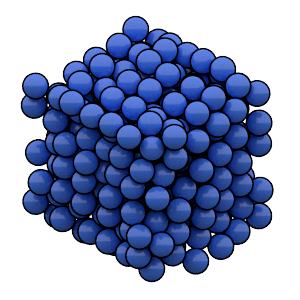

In [183]:
# Play around with a and t to view different structures :)
a = avals[0]
t = temps[-1]
snapshot = hoomd.data.gsd_snapshot('outputs/eq_trajectory{}{}.gsd'.format(a,t),frame=-1)
ex_render.render_sphere_frame(snapshot)

In [189]:
print("a = ", a, "t = ", t)
r = t_results_dense[(a,t)][4][:,0]
rdf = t_results_dense[(a,t)][4][:,1]
plt.plot(r,rdf,label="T = {}".format(t), alpha=0.6)
peaks = get_peaks(rdf)
for peak_ind in peaks:
    plt.scatter(r[peak_ind],rdf[peak_ind],c='k')
plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('r', fontsize=18)
plt.ylabel('g_AA(r)', fontsize=18)
plt.show()

a =  0.9 t =  3.0


In [180]:
# t_results_dense = <U>/N, decorr time, std dev U, rel error U, rdf
# phase = a,t,phase
phase = []
for t in temps:
    for a in avals:
        rdf = t_results_dense[(a,t)][4][:,1]
        peaks = get_peaks(rdf)
        if len(peaks) > 3: # solid
            phase.append([a,t,4])
        elif len(peaks) <= 1: # gas
            phase.append([a,t,1])
        else:
            phase.append([a,t,len(peaks)])
            
phase = np.array(phase)

In [339]:
# copying contour map code from cmelab/LabStuff/evan_analysis_scripts/p3ht/stacking_heatmaps.py
pad = 0.05
ypad = 0.2
x = 1/phase[:,0]**3 # density
y = phase[:,1] # temp
z = phase[:,2]
xi, yi = np.mgrid[x.min()-pad:x.max()+pad:100j, y.min()-ypad:y.max()+ypad:100j]
zi = scipy.interpolate.griddata((x,y), z, (xi, yi), method = 'nearest') # also try linear or cubic! :)

plt.scatter(x, y, c='k', marker='x', zorder=2)
plt.contourf(xi, yi, zi, 20, cmap = plt.cm.get_cmap('rainbow'), zorder = 1)
plt.xlabel("Density", fontsize=16)
plt.ylabel("Temperature", fontsize=16)
plt.title("Phase Diagram", fontsize=18)

plt.xlim([np.min(x)-pad, np.max(x)+pad])
plt.ylim([np.min(y)-ypad, np.max(y)+ypad])
plt.xticks(np.arange(0.3,1.4,0.2));

Cool--red = solid, yellow/green = solid/liquid, light blue = liquid, purple = gas! (Fun Fact: Initially I had hard-coded a specific density in the get_peaks function on accident, so I was so disappointed because this figure was really boring! Not-working-code really makes you appreciate working-code.) It doesn't look exactly like the phase diagram you showed in class--there isn't as much of a liquid/vapor bubble at low density low temps, there is a slight bump around T = 0.8 density ~ 0.4.

(Also I was showing this to Evan and Matty, and they showed me Evan's perylene paper which has almost the same figure!)

So--why does this phase diagram have solid/liquid gaps between the solid regions at density = 1.4 T = 0.8 and 0.4? I think it could be one of two reasons:

(1) kinetic trapping: at these low temps and high densities particles get trapped and can't reach their ideal conformations.

(2) the number of peaks in the rdf is not enough of a metric to determine the phase.

<span style="color:purple">1. Characterize your model’s behavior:
    
<span style="color:purple">a. Above what temperature is your system “hot”? How do you know?
    
In general the system is hot above $T^{*}=1$. We know this from the fact that when using unitless temperature, $T^{*}=\frac{k_{b}T}{\epsilon}$, and in our system $\epsilon=1$. The thermostat in MD uses the set temperature to modulate the kinetic energy of the particles; there must be some degree of randomness, but if $T^{*}>\epsilon$, then on average the system will have enough kinetic energy to get out of the potential well. 
We can also look at the rdf, but it is much faster to just know things. --> However if the question we are actually asking is what is the melting/vaporization temp, then we should look at the rdf.

<span style="color:purple">b. Below what temperature is your system “frozen”? How do you know?
    
Well, I think frozen is not the opposite of hot. When $T^{*}<\epsilon$, the system may not have enough kinetic energy to escape the potential well. For example the liquid/solid gaps I mentioned above. Let's examine whether these are kinetically trapped:

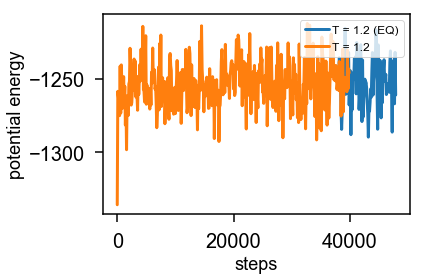

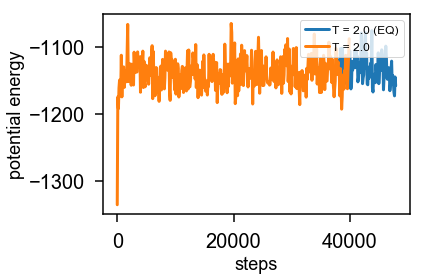

In [5]:
a=1.2

t=1.2

logname = "outputs/eq_log-output{}{}.log".format(a,t)
data = np.genfromtxt(fname=logname, skip_header=True)
plt.plot(data[:,0],data[:,1],label="T = {} (EQ)".format(t))
logname = "outputs/log-output{}{}.log".format(a,t)
data = np.genfromtxt(fname=logname, skip_header=True)
plt.plot(data[:,0],data[:,1],label="T = {}".format(t))

plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('steps', fontsize=18)
plt.ylabel('potential energy', fontsize=18)

plt.show()

t=2.0
logname = "outputs/eq_log-output{}{}.log".format(a,t)
data = np.genfromtxt(fname=logname, skip_header=True)
plt.plot(data[:,0],data[:,1],label="T = {} (EQ)".format(t))
logname = "outputs/log-output{}{}.log".format(a,t)
data = np.genfromtxt(fname=logname, skip_header=True)
plt.plot(data[:,0],data[:,1],label="T = {}".format(t))

plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('steps', fontsize=18)
plt.ylabel('potential energy', fontsize=18)

plt.show()

<span style="color:purple">2. Characterize your model’s performance:
    
<span style="color:purple">b. How long does it take to equilibrate in-between?

OK, so I already talked about how the frozen system took 40,000 steps to equilibrate and the above graphs show that the system at in-between and hot temperatures equilibrates much faster. In the table below I'll also show the decorrelation time and standard deviation for the equilibrated systems are both very good--if the tolerance is that we're looking for 20 independent samples, we have at least double that for the longest decorrelation time.

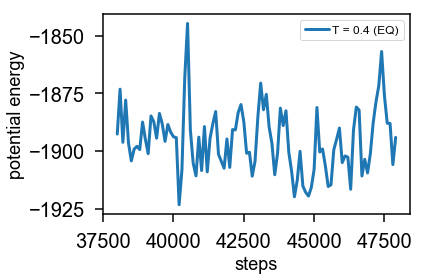

In [11]:
t=0.4

logname = "outputs/eq_log-output{}{}.log".format(a,t)
data = np.genfromtxt(fname=logname, skip_header=True)
plt.plot(data[:,0],data[:,1],label="T = {} (EQ)".format(t))

plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('steps', fontsize=18)
plt.ylabel('potential energy', fontsize=18)
plt.show()

In [335]:
# t_results_dense = <U>/N, decorr time, std dev U, rel error U, rdf
print(" T    rho       <U>/N    decorr(steps)   std dev     rel error")
for a in avals:
    for t in temps:
        print("{}  {:.2f}\t{:.2f}    \t{:.0f} \t  {:.2f}   \t{:.2f}".format(t, 1/a**3, 
                                                                     t_results_dense[(a,t)][0], 
                                                                     t_results_dense[(a,t)][1], 
                                                                     t_results_dense[(a,t)][2],
                                                                     t_results_dense[(a,t)][3],
                                                                     t_results_dense[(a,t)][4]))

 T    rho       <U>/N    decorr(steps)   std dev     rel error
0.2  1.37	-3.00    	2 	  4.23   	0.04
0.4  1.37	-1.90    	2 	  11.91   	0.18
0.6  1.37	-3.79    	2 	  11.27   	0.09
0.8  1.37	-1.36    	1 	  14.09   	0.30
1.0  1.37	-2.29    	2 	  25.94   	0.33
1.2  1.37	-2.51    	2 	  34.50   	0.40
1.4  1.37	-2.16    	2 	  44.03   	0.60
1.6  1.37	-1.53    	2 	  29.56   	0.56
1.8  1.37	-1.21    	2 	  36.30   	0.88
2.0  1.37	-0.99    	2 	  40.87   	1.21
3.0  1.37	0.42    	2 	  71.87   	5.05
0.2  1.00	-7.40    	23 	  11.71   	0.05
0.4  1.00	-7.04    	1 	  7.72   	0.03
0.6  1.00	-6.82    	2 	  12.39   	0.05
0.8  1.00	-6.55    	1 	  16.42   	0.07
1.0  1.00	-5.81    	4 	  19.35   	0.10
1.2  1.00	-5.52    	1 	  30.43   	0.16
1.4  1.00	-5.25    	2 	  28.00   	0.16
1.6  1.00	-4.98    	1 	  32.74   	0.19
1.8  1.00	-4.74    	2 	  36.11   	0.22
2.0  1.00	-4.51    	2 	  41.62   	0.27
3.0  1.00	-3.44    	2 	  51.02   	0.43
0.2  0.75	-6.59    	1 	  4.83   	0.02
0.4  0.75	-5.78    	10 	  14.51   	0.07
0.6

<span style="color:purple">1. Characterize your model’s behavior:
    
<span style="color:purple">d. What’s the standard deviation and number of samples for every measurement you report?
   
I think I reported these for every measurement--my equilibration runs were always 10,000 steps so instead I reported my decorrelation time, but the number of independent samples is just 10,000/decorrelation time.

<span style="color:purple">2. Characterize your model’s performance:

<span style="color:purple">e. Did you use this information when collecting data for part 1?
    
Yes, I chose a length that worked for what I knew to be the slowest to equilibrate and used that for all state points. I saved a little time by not writing out the RDF until everything was equilibrated.

In [334]:
# t_results_dense = <U>/N, decorr time, std dev U, rel error U, rdf
print(" T    rho       <U>/N    decorr(steps)   std dev     rel error")
for t in [0.4,0.8]:
    a = 0.9
    print("{}  {:.2f}\t{:.2f}    \t{:.0f} \t  {:.2f}   \t{:.2f}".format(t, 1/a**3, 
                                                                 t_results_dense[(a,t)][0], 
                                                                 t_results_dense[(a,t)][1], 
                                                                 t_results_dense[(a,t)][2],
                                                                 t_results_dense[(a,t)][3],
                                                                 t_results_dense[(a,t)][4]))

 T    rho       <U>/N    decorr(steps)   std dev     rel error
0.4  1.37	-1.90    	2 	  11.91   	0.18
0.8  1.37	-1.36    	1 	  14.09   	0.30


Hmmm... I was sort of thinking that something would pop out to me from looking at the data, but it doesn't. I know that this system really has the potential to be kinetically frozen because the temperature is low (it doesn't have enough energy to escape the potential well) and it is quite densely packed (other particles could be in the way).

Actually--when I change the sorting order of the above list from T first then a, to a first then T, I noticed that the per particle energies for T=0.4 and 0.8 don't follow the trend for that density, which suggests these systems might be stuck in a local minima!

Anyway to answer the original question, $T^{*}<1$ has the potential to be frozen.

<span style="color:purple">1. Characterize your model’s behavior:

<span style="color:purple">c. How does the system’s total energy, potential energy, kinetic energy, heat capacity, and structure vary from frozen to too hot?
    
OK, I've looked at potential energy: potential energy decreases when temperature increases because the potential energy is lowered (made more negative) when particles clump together and particles are less likely to clump when they are hot (they have enough kinetic energy to escape the potential well).
Occaisionally potential energy can even become positive if we squeeze the particles together or give them enough kinetic energy (temperature) that they can come close enough that they enter the repulsive part of the potential.

I've also already looked at structure using the rdf: structure can vary based on temp and density and the number of peaks in an rdf can be used as a crude metric to make a phase diagram.

Let's look at kinetic energy:

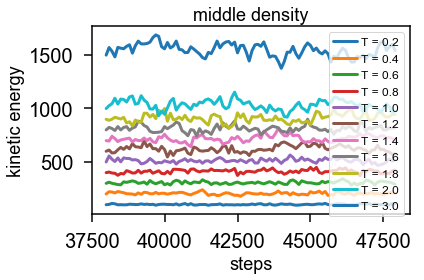

In [257]:
# logfile -> [step, 'potential_energy', 'kinetic_energy', 'pressure', temperature'],

a=1.5

for t in temps:
    logname = "outputs/eq_log-output{}{}.log".format(a,t)
    data = np.genfromtxt(fname=logname, skip_header=True)
    plt.plot(data[:,0],data[:,2],label="T = {}".format(t))

plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('steps', fontsize=18)
plt.ylabel('kinetic energy', fontsize=18)
plt.title("low density", fontsize=18)

plt.show()

a=1.2

for t in temps:
    logname = "outputs/eq_log-output{}{}.log".format(a,t)
    data = np.genfromtxt(fname=logname, skip_header=True)
    plt.plot(data[:,0],data[:,2],label="T = {}".format(t))

plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('steps', fontsize=18)
plt.ylabel('kinetic energy', fontsize=18)
plt.title("middle density", fontsize=18)

plt.show()


a=0.9

for t in temps:
    logname = "outputs/eq_log-output{}{}.log".format(a,t)
    data = np.genfromtxt(fname=logname, skip_header=True)
    plt.plot(data[:,0],data[:,2],label="T = {}".format(t))

plt.legend(fontsize=12, loc="upper right", framealpha=0.8, frameon=True)
plt.xlabel('steps', fontsize=18)
plt.ylabel('kinetic energy', fontsize=18)
plt.title("high density", fontsize=18)

plt.show()

OK, that looks about how I was expecting. Higher temperatures have higher kinetic energies and greater fluctuations. I'm not seeing a huge effect from density, so I'm going to ignore it for now. The total energy then for a system is PE + KE and heat capacity ($C_{v}$) can be calculated by $C_{v} = \frac{1}{k_{b}T}\big(<U^{2}>-<U>^{2}\big)$

In [311]:
a=1.5
table = PrettyTable(['T', 'PE', 'KE', 'total E', 'Cv'])
for t in temps:
    logname = "outputs/eq_log-output{}{}.log".format(a,t)
    data = np.genfromtxt(fname=logname, skip_header=True)
    cv = 1/t * (np.mean(data[:,1]**2)-np.mean(data[:,1])**2)

    table.add_row([t, "{:.1f}".format(np.mean(data[:,1])), "{:.1f}".format(np.mean(data[:,2])), 
                  "{:.1f}".format(np.mean(data[:,1])+np.mean(data[:,2])), "{:.1f}".format(cv)])
                                                        
print("Low density (d={:.2f})".format(1/a))
print(table)

a=0.9
table = PrettyTable(['T', 'PE', 'KE', 'total E', 'Cv'])
for t in temps:
    logname = "outputs/eq_log-output{}{}.log".format(a,t)
    data = np.genfromtxt(fname=logname, skip_header=True)
    cv = 1/t * (np.mean(data[:,1]**2)-np.mean(data[:,1])**2)
    
    table.add_row([t, "{:.1f}".format(np.mean(data[:,1])), "{:.1f}".format(np.mean(data[:,2])), 
                  "{:.1f}".format(np.mean(data[:,1])+np.mean(data[:,2])), "{:.1f}".format(cv)])
                                                        
print("\nHigh density (d={:.2f})".format(1/a))
print(table)

Low density (d=0.67)
+-----+---------+--------+---------+--------+
|  T  |    PE   |   KE   | total E |   Cv   |
+-----+---------+--------+---------+--------+
| 0.2 | -1927.9 | 101.9  | -1826.1 | 147.5  |
| 0.4 | -1750.9 | 203.1  | -1547.8 | 439.8  |
| 0.6 | -1482.4 | 307.5  | -1174.9 | 959.3  |
| 0.8 | -1177.2 | 411.5  |  -765.7 | 2177.4 |
| 1.0 |  -800.9 | 513.1  |  -287.9 | 835.1  |
| 1.2 |  -690.1 | 616.0  |  -74.2  | 324.9  |
| 1.4 |  -656.7 | 716.5  |   59.9  | 207.4  |
| 1.6 |  -629.0 | 817.2  |  188.3  | 161.0  |
| 1.8 |  -605.5 | 920.8  |  315.2  | 160.0  |
| 2.0 |  -592.1 | 1032.9 |  440.9  | 112.1  |
| 3.0 |  -536.4 | 1535.3 |  998.9  | 147.6  |
+-----+---------+--------+---------+--------+

High density (d=1.11)
+-----+---------+--------+---------+--------+
|  T  |    PE   |   KE   | total E |   Cv   |
+-----+---------+--------+---------+--------+
| 0.2 | -1030.0 | 100.9  |  -929.1 |  89.6  |
| 0.4 |  -650.0 | 203.2  |  -446.9 | 354.3  |
| 0.6 | -1301.4 | 305.1  |  -996.3 |

As temperature is increased eventually the kinetic energy overtakes the potential energy. The one value where PE is positive suggests the system is unstable and probably unphysical without suffient external force being applied (e.g. a high-pressure bomb).

The heat capacity seems a little screwy though. The low density system should have overall lower heat capacities--which it does for the higher temperatures. I think the reason we don't see this for the low temperatures is kinetic trapping. We would also expect that the heat capacity would increase as the temperature increases within phases, but the heat capacity of a solid should be higher than a liquid, liquid higher than gas. In this data it looks like we have a max heat capacity at T = 0.8 for the low density and T = 1.4 for the high density, which according to our phase diagram correspond to liquid and solid/liquid phases, respectively. 

<span style="color:purple">3. Contrast your system with an ideal gas:
    
<span style="color:purple">a. How does the structure of your model vary with state, and how does it compare to particles with no interactions?
    
(See phase diagram) The structure of the particles depends on denisty and temperature. Particles with no interaction would depend only on density because the temperature would have no effect--there is no potential well to escape; why would kinetic energy be necessary to escape it?
    
<span style="color:purple">b. Does the heat capacity of your system depend on state differently than an ideal gas?
    
Yes, these particles have interactions. An ideal gas assumes no interactions. The heat capacity then depends only on density while our system also depends on temperature.
    
<span style="color:purple">c. Can you derive or numerically determine an equation of state?

To determine an equation of state, let's plot the pressure of different densities at one temp and fit that to a curve!

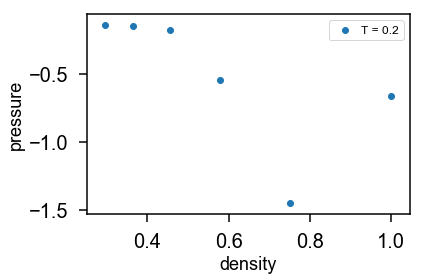

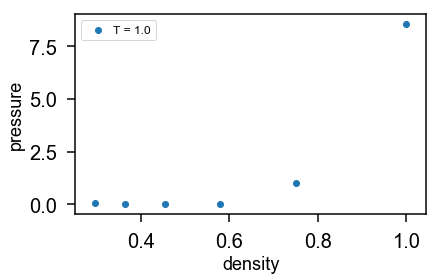

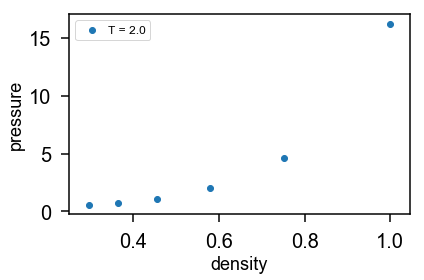

In [17]:
rho_p = {}
for t in [0.2,1.0,2.0]:
    densities = []
    pressures = []
    for a in avals[1:]: # leaving out the highest density (lowest a value) because it makes the plot hard to see
        logname = "outputs/eq_log-output{}{}.log".format(a,t)
        data = np.genfromtxt(fname=logname, skip_header=True) # step, pot_e, kin_e, pressure, temp 
        densities.append(1/a**3)
        pressures.append(np.mean(data[:,3]))
    rho_p[t] = np.dstack([densities,pressures])[0] 
    
    plt.scatter(densities,pressures,label="T = {}".format(t))
    plt.legend(fontsize=12, loc="best", framealpha=0.8, frameon=True)
    plt.xlabel('density', fontsize=18)
    plt.ylabel('pressure', fontsize=18)
    plt.show()

Neat! The graphs look like we expect--at low temp the pressure vs density looks kind of cubic and at higher temps it looks parabolic.

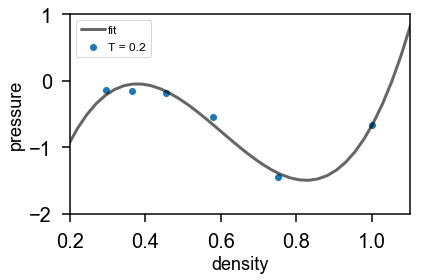

Fit function: 32.27x³ + -58.31x² + 30.26x + -4.89
Average error of fit parameters: 6.68


In [18]:
# curve fitting
# https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.curve_fit.html
t= 0.2

def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

xs = np.linspace(0,1.2,50)

opt_param, pcov = opt.curve_fit(cubic, rho_p[t][:,0], rho_p[t][:,1])

plt.plot(xs, cubic(xs, *opt_param), label="fit", c='k', alpha=0.6)
plt.scatter(rho_p[t][:,0],rho_p[t][:,1],label="T = {}".format(t))
plt.legend(fontsize=12, loc="best", framealpha=0.8, frameon=True)
plt.xlabel('density', fontsize=18)
plt.ylabel('pressure', fontsize=18)
plt.xlim(0.2,1.1)
plt.ylim(-2,1)
plt.show()

print("Fit function: {:.2f}x\u00b3 + {:.2f}x\u00b2 + {:.2f}x + {:.2f}".format(*opt_param))
print("Average error of fit parameters: {:.2f}".format(np.mean(np.sqrt(np.diag(pcov)))))

Well, that looks OK. Adding in that high density point doesn't help--the average error increases to 33.75. In order to get a better fit, I would need to add more points around the tight turn (d = 0.65, 0.9, etc). Let's look at the other temperatures:

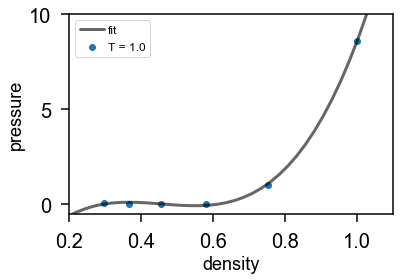

Fit function: 58.57x³ + -80.35x² + 35.25x + -4.90
Average error of fit parameters: 5.11


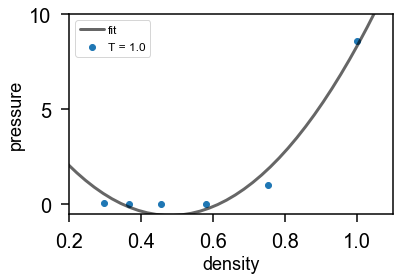

Fit function: 33.06x² + -31.81x + 7.07
Average error of fit parameters: 5.06


In [26]:
t= 1.0

def square(x, a, b, c):
    return a*x**2 + b*x + c

opt_param, pcov = opt.curve_fit(cubic, rho_p[t][:,0], rho_p[t][:,1])

plt.plot(xs, cubic(xs, *opt_param), label="fit", c='k', alpha=0.6)
plt.scatter(rho_p[t][:,0],rho_p[t][:,1],label="T = {}".format(t))
plt.legend(fontsize=12, loc="best", framealpha=0.8, frameon=True)
plt.xlabel('density', fontsize=18)
plt.ylabel('pressure', fontsize=18)
plt.xlim(0.2,1.1)
plt.ylim(-0.5,10)
plt.show()

print("Fit function: {:.2f}x\u00b3 + {:.2f}x\u00b2 + {:.2f}x + {:.2f}".format(*opt_param))
print("Average error of fit parameters: {:.2f}".format(np.mean(np.sqrt(np.diag(pcov)))))

opt_param, pcov = opt.curve_fit(square, rho_p[t][:,0], rho_p[t][:,1])

plt.plot(xs, square(xs, *opt_param), label="fit", c='k', alpha=0.6)
plt.scatter(rho_p[t][:,0],rho_p[t][:,1],label="T = {}".format(t))
plt.legend(fontsize=12, loc="best", framealpha=0.8, frameon=True)
plt.xlabel('density', fontsize=18)
plt.ylabel('pressure', fontsize=18)
plt.xlim(0.2,1.1)
plt.ylim(-0.5,10)
plt.show()

print("Fit function: {:.2f}x\u00b2 + {:.2f}x + {:.2f}".format(*opt_param))
print("Average error of fit parameters: {:.2f}".format(np.mean(np.sqrt(np.diag(pcov)))))

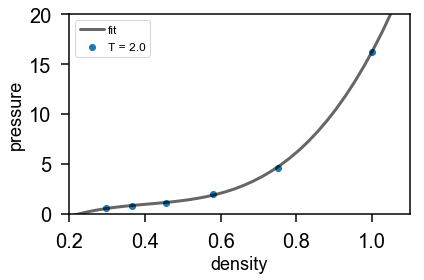

Fit function: 63.87x³ + -78.03x² + 35.05x + -4.67
Average error of fit parameters: 7.21


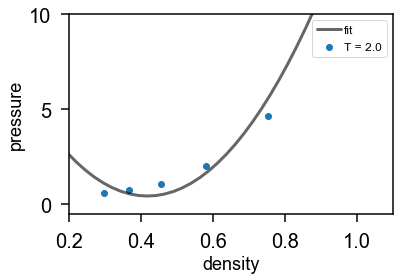

Fit function: 45.65x² + -38.08x + 8.38
Average error of fit parameters: 5.54


In [27]:
t = 2.0

opt_param, pcov = opt.curve_fit(cubic, rho_p[t][:,0], rho_p[t][:,1])

plt.plot(xs, cubic(xs, *opt_param), label="fit", c='k', alpha=0.6)
plt.scatter(rho_p[t][:,0],rho_p[t][:,1],label="T = {}".format(t))
plt.legend(fontsize=12, loc="best", framealpha=0.8, frameon=True)
plt.xlabel('density', fontsize=18)
plt.ylabel('pressure', fontsize=18)
plt.xlim(0.2,1.1)
plt.ylim(0,20)
plt.show()

print("Fit function: {:.2f}x\u00b3 + {:.2f}x\u00b2 + {:.2f}x + {:.2f}".format(*opt_param))
print("Average error of fit parameters: {:.2f}".format(np.mean(np.sqrt(np.diag(pcov)))))

opt_param, pcov = opt.curve_fit(square, rho_p[t][:,0], rho_p[t][:,1])

plt.plot(xs, square(xs, *opt_param), label="fit", c='k', alpha=0.6)
plt.scatter(rho_p[t][:,0],rho_p[t][:,1],label="T = {}".format(t))
plt.legend(fontsize=12, loc="best", framealpha=0.8, frameon=True)
plt.xlabel('density', fontsize=18)
plt.ylabel('pressure', fontsize=18)
plt.xlim(0.2,1.1)
plt.ylim(-0.5,10)
plt.show()

print("Fit function: {:.2f}x\u00b2 + {:.2f}x + {:.2f}".format(*opt_param))
print("Average error of fit parameters: {:.2f}".format(np.mean(np.sqrt(np.diag(pcov)))))

Van der Waals equation of state:

$ (P+a\rho^{2})(\frac{1}{\rho}-b)=RT $

If we solve the VDW equation of state for P we get:

$ P = \frac{RT\rho-a\rho^{2}-ab\rho^{3}}{1-b\rho} $

which is tricky to fit, and I keep running into problems when I try because of the $1-b\rho$ in the denominator. Anyway, I think the virial expansion of the equation of state should fit to a polynomial and it looks like going up to the cubic term fits the data pretty well.

T = 0.2 Fit function: $P = 32.27\rho³ -58.31\rho² + 30.26\rho -4.89$

T = 1.0 Fit function: $P = 58.57\rho³ -80.35\rho² + 35.25\rho -4.90$

T = 2.0 Fit function: $P = 63.87\rho³ -78.03\rho² + 35.05\rho -4.67$

I'd even go as far to say that the coefficients for the different polynomial terms across the temperatures look pretty consistent. I think the coefficients would be functions of temperature as well, which I didn't account for. Let's see if I can figure a way to do that:

In [69]:
coeffs = [np.mean([32.27,58.57,63.87]),
          np.mean([-58.31,-80.35,-78.03]),
          np.mean([30.26,35.25,35.05]),
          np.mean([-4.89,-4.90,-4.67])]

def cubic_t(x, t, a, b, c, d):
    return a*(t**(1/3))*x**3 + b*(t**(1/5))*x**2 + c*x + d


t=0.2
plt.plot(xs, cubic_t(xs, t, *coeffs), label="fit {}".format(t), alpha=0.6)
plt.scatter(rho_p[t][:,0],rho_p[t][:,1],label="T = {}".format(t))
t=1
plt.plot(xs, cubic_t(xs, t, *coeffs), label="fit {}".format(t), alpha=0.6)
plt.scatter(rho_p[t][:,0],rho_p[t][:,1],label="T = {}".format(t))
t=2
plt.plot(xs, cubic_t(xs, t, *coeffs), label="fit {}".format(t), alpha=0.6)
plt.scatter(rho_p[t][:,0],rho_p[t][:,1],label="T = {}".format(t))
plt.legend(fontsize=12, loc="best", framealpha=0.8, frameon=True)
plt.xlabel('density', fontsize=18)
plt.ylabel('pressure', fontsize=18)
plt.xlim(0.2,1.1)
plt.ylim(-2,20)
plt.show()

In [70]:
# messing with t and the coefficients
print(coeffs[0])
print(32.27/(0.2**(1/3)))
print(58.57/(1**(1/3)))
print(63.87/(2**(1/3)))
print(coeffs[0]*(0.2**(1/3)))
print(coeffs[1]*(0.2**(1/5)))
print(coeffs[1]*(1**(1/5)))
print(coeffs[1]*(2**(1/5)))

51.57
55.180923799257016
58.57
50.693652594604444
30.1583189519275
-52.35083510743995
-72.23
-82.97048218143586


OK, so I hoped I could get it to fit by multiplying the coeffients with the temperature... It doesn't really work, but it works a little better than just using the average coefficient.

<span style="color:purple">4. Summarize which metrics you found most useful for describing your system’s behavior, which specific simulation and state point was your favorite (and why), and any revelations you had while working towards 1-3. 
    
The metric which I found the most useful was the RDF. The idea that you could use the number of peaks in the RDF to automate the determination of which phase the system is in is REALLY COOL to me. :) I don't have a favorite state point or anything, but the part of this project which I had the most fun with was making the phase diagram, which I guess wasn't really part of the assignment, but it just sounded fun to try and make. I don't think I had any revelations, but I am definitely thinking about how to use snippets of this code for other things. Overall, a fun project.